# Text-to-Image Generation with Stable Diffusion and OpenVINO™

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It is trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

General diffusion models are machine learning systems that are trained to denoise random gaussian noise step by step, to get to a sample of interest, such as an image.
Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference. OpenVINO brings capabilities to run model inference on Intel hardware and opens the door to the fantastic world of diffusion models for everyone!

Model capabilities are not limited text-to-image only, it also is able solve additional tasks, for example text-guided image-to-image generation and inpainting. This tutorial also considers how to run text-guided image-to-image generation using Stable Diffusion.


This notebook demonstrates how to convert and run stable diffusion model using OpenVINO.

Notebook contains the following steps:

1. Create pipeline with PyTorch models.
2. Convert models to OpenVINO IR format, using model conversion API.
3. Run Stable Diffusion pipeline with OpenVINO.


<a id="0"></a>
### Table of content:
- [Prerequisites](#1)
- [Create PyTorch Models pipeline](#2)
- [Convert models to OpenVINO Intermediate representation (IR) format](#3)
    - [Text Encoder](#4)
    - [U-net](#5)
    - [VAE](#6)
- [Prepare Inference Pipeline](#7)
- [Configure Inference Pipeline](#8)
    - [Text-to-Image generation](#9)
    - [Image-to-Image generation](#10)

<a id="1"></a>
## Prerequisites [&#8657;](#0)

**The following is needed only if you want to use the original model. If not, you do not have to do anything. Just run the notebook.**

>**Note**:
>The original model (for example, `stable-diffusion-v1-4`) requires you to accept the model license before downloading or using its weights. Visit the [stable-diffusion-v1-4 card](https://huggingface.co/CompVis/stable-diffusion-v1-4) to read and accept the license before you proceed.
>To use this diffusion model, you must be a registered user in 🤗 Hugging Face Hub. You will need to use an access token for the code below to run. For more information on access tokens, refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).
>You can login on Hugging Face Hub in notebook environment, using following code:
```python

## login to huggingfacehub to get access to pretrained model
from huggingface_hub import notebook_login, whoami

try:
    whoami()
    print('Authorization token already provided')
except OSError:
    notebook_login()
```

This tutorial uses a Stable Diffusion model, fine-tuned using images from Midjourney v4 (another popular solution for text to image generation).
You can find more details about this model on the [model card](https://huggingface.co/prompthero/openjourney). The same steps for conversion and running the pipeline are applicable to other solutions based on Stable Diffusion.


In [1]:
!pip install -q "openvino==2023.1.0dev20230811"
!pip install -q "diffusers[torch]>=0.9.0"
!pip install -q "huggingface-hub>=0.9.1"
!pip install -q gradio

<a id="2"></a>
## Create PyTorch Models pipeline [&#8657;](#0)
`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, load the pre-trained weights of all components of the model.

In [2]:
from diffusers import StableDiffusionPipeline
import gc

pipe = StableDiffusionPipeline.from_pretrained("prompthero/openjourney").to("cpu")
text_encoder = pipe.text_encoder
text_encoder.eval()
unet = pipe.unet
unet.eval()
vae = pipe.vae
vae.eval()

del pipe
gc.collect()

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


0

<a id="3"></a>
## Convert models to OpenVINO Intermediate representation (IR) format [&#8657;](#0)

Staring from 2023.0 release, OpenVINO supports direct conversion PyTorch models to OpenVINO IR format. You need to provide a model object and input data for model tracing. Optionally, you can declare expected input format for model - shapes, data types.
To take advantage of advanced OpenVINO optimization tools and features, model should be converted to IR format using `ov.convert_model` and saved on disk (by default in compressed to FP16 weights representation) for next deployment using `ov.save_model`.

The model consists of three important parts:

* Text Encoder for creation condition to generate image from text prompt.
* Unet for step by step denoising latent image representation.
* Autoencoder (VAE) for encoding input image to latent space (if required) and decoding latent space to image back after generation.

Let us convert each part.

<a id="4"></a>
### Text Encoder [&#8657;](#0)

The text-encoder is responsible for transforming the input prompt, for example, "a photo of an astronaut riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple transformer-based encoder that maps a sequence of input tokens to a sequence of latent text embeddings.

Input of the text encoder is the tensor `input_ids` which contains indexes of tokens from text processed by tokenizer and padded to maximum length accepted by model. Model outputs are two tensors: `last_hidden_state` - hidden state from the last MultiHeadAttention layer in the model and `pooler_out` - Pooled output for whole model hidden states.

In [3]:
from pathlib import Path
import torch
import openvino as ov

TEXT_ENCODER_OV_PATH = Path("text_encoder.xml")

def cleanup_torchscript_cache():
    """
    Helper for removing cached model representation
    """
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()

def convert_encoder(text_encoder: torch.nn.Module, ir_path:Path):
    """
    Convert Text Encoder mode. 
    Function accepts text encoder model, and prepares example inputs for conversion, 
    Parameters: 
        text_encoder (torch.nn.Module): text_encoder model from Stable Diffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    input_ids = torch.ones((1, 77), dtype=torch.long)
    # switch model to inference mode
    text_encoder.eval()

    # disable gradients calculation for reducing memory consumption
    with torch.no_grad():
        # Export model to IR format
        ov_model = ov.convert_model(text_encoder, example_input=input_ids, input=[(1,77),])
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f'Text Encoder successfully converted to IR and saved to {ir_path}')
    

if not TEXT_ENCODER_OV_PATH.exists():
    convert_encoder(text_encoder, TEXT_ENCODER_OV_PATH)
else:
    print(f"Text encoder will be loaded from {TEXT_ENCODER_OV_PATH}")

del text_encoder
gc.collect()

Text encoder will be loaded from text_encoder.xml


0

<a id="5"></a>
### U-net [&#8657;](#0)

Unet model has three inputs:

* `sample` - latent image sample from previous step. Generation process has not been started yet, so you will use random noise.
* `timestep` - current scheduler step.
* `encoder_hidden_state` - hidden state of text encoder.

Model predicts the `sample` state for the next step.

In [4]:
import numpy as np

UNET_OV_PATH = Path('unet.xml')

dtype_mapping = {
    torch.float32: ov.Type.f32,
    torch.float64: ov.Type.f64
}


def convert_unet(unet:torch.nn.Module, ir_path:Path):
    """
    Convert U-net model to IR format. 
    Function accepts unet model, prepares example inputs for conversion, 
    Parameters: 
        unet (StableDiffusionPipeline): unet from Stable Diffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    # prepare inputs
    encoder_hidden_state = torch.ones((2, 77, 768))
    latents_shape = (2, 4, 512 // 8, 512 // 8)
    latents = torch.randn(latents_shape)
    t = torch.from_numpy(np.array(1, dtype=float))
    dummy_inputs = (latents, t, encoder_hidden_state)
    input_info = []
    for input_tensor in dummy_inputs:
        shape = ov.PartialShape(tuple(input_tensor.shape))
        element_type = dtype_mapping[input_tensor.dtype]
        input_info.append((shape, element_type))

    unet.eval()
    with torch.no_grad():
        ov_model = ov.convert_model(unet, example_input=dummy_inputs, input=input_info)
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f'Unet successfully converted to IR and saved to {ir_path}')


if not UNET_OV_PATH.exists():
    convert_unet(unet, UNET_OV_PATH)
    gc.collect()
else:
    print(f"Unet will be loaded from {UNET_OV_PATH}")
del unet
gc.collect()

Unet will be loaded from unet.xml


0

<a id="6"></a>
### VAE [&#8657;](#0)

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the U-Net model. The decoder, conversely, transforms the latent representation back into an image.

During latent diffusion training, the encoder is used to get the latent representations (latents) of the images for the forward diffusion process, which applies more and more noise at each step. During inference, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. When you run inference for text-to-image, there is no initial image as a starting point. You can skip this step and directly generate initial random noise.

As the encoder and the decoder are used independently in different parts of the pipeline, it will be better to convert them to separate models.

In [5]:
VAE_ENCODER_OV_PATH = Path("vae_encoder.xml")

def convert_vae_encoder(vae: torch.nn.Module, ir_path: Path):
    """
    Convert VAE model for encoding to IR format. 
    Function accepts vae model, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for conversion, 
    Parameters: 
        vae (torch.nn.Module): VAE model from StableDiffusio pipeline 
        ir_path (Path): File for storing model
    Returns:
        None
    """
    class VAEEncoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, image):
            return self.vae.encode(x=image)["latent_dist"].sample()
    vae_encoder = VAEEncoderWrapper(vae)
    vae_encoder.eval()
    image = torch.zeros((1, 3, 512, 512))
    with torch.no_grad():
        ov_model = ov.convert_model(vae_encoder, example_input=image, input=[((1,3,512,512),)])
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f'VAE encoder successfully converted to IR and saved to {ir_path}')


if not VAE_ENCODER_OV_PATH.exists():
    convert_vae_encoder(vae, VAE_ENCODER_OV_PATH)
else:
    print(f"VAE encoder will be loaded from {VAE_ENCODER_OV_PATH}")

VAE_DECODER_OV_PATH = Path('vae_decoder.xml')

def convert_vae_decoder(vae: torch.nn.Module, ir_path: Path):
    """
    Convert VAE model for decoding to IR format. 
    Function accepts vae model, creates wrapper class for export only necessary for inference part, 
    prepares example inputs for conversion, 
    Parameters: 
        vae (torch.nn.Module): VAE model frm StableDiffusion pipeline
        ir_path (Path): File for storing model
    Returns:
        None
    """
    class VAEDecoderWrapper(torch.nn.Module):
        def __init__(self, vae):
            super().__init__()
            self.vae = vae

        def forward(self, latents):
            return self.vae.decode(latents)
    
    vae_decoder = VAEDecoderWrapper(vae)
    latents = torch.zeros((1, 4, 64, 64))

    vae_decoder.eval()
    with torch.no_grad():
        ov_model = ov.convert_model(vae_decoder, example_input=latents, input=[((1,4,64,64),)])
    ov.save_model(ov_model, ir_path)
    del ov_model
    cleanup_torchscript_cache()
    print(f'VAE decoder successfully converted to IR and saved to {ir_path}')


if not VAE_DECODER_OV_PATH.exists():
    convert_vae_decoder(vae, VAE_DECODER_OV_PATH)
else:
    print(f"VAE decoder will be loaded from {VAE_DECODER_OV_PATH}")

del vae
gc.collect()

VAE encoder will be loaded from vae_encoder.xml
VAE decoder will be loaded from vae_decoder.xml


0

<a id="7"></a>
## Prepare Inference Pipeline [&#8657;](#0)

Putting it all together, let us now take a closer look at how the model works in inference by illustrating the logical flow.

![sd-pipeline](https://user-images.githubusercontent.com/29454499/260981188-c112dd0a-5752-4515-adca-8b09bea5d14a.png)

As you can see from the diagram, the only difference between Text-to-Image and text-guided Image-to-Image generation in approach is how initial latent state is generated. In case of Image-to-Image generation, you additionally have an image encoded by VAE encoder mixed with the noise produced by using latent seed, while in Text-to-Image you use only noise as initial latent state.
The stable diffusion model takes both a latent image representation of size $64 \times 64$ and a text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder as an input.

Next, the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, it is recommended to use one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)(you will use it in your pipeline)

Theory on how the scheduler algorithm function works is out of scope for this notebook. Nonetheless, in short, you should remember that you compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, refer to the recommended [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated given number of times (by default 50) to step-by-step retrieve better latent image representations.
When complete, the latent image representation is decoded by the decoder part of the variational auto encoder.

In [6]:
import inspect
from typing import List, Optional, Union, Dict

import PIL
import cv2

from transformers import CLIPTokenizer
from diffusers.pipelines.pipeline_utils import DiffusionPipeline
from diffusers.schedulers import DDIMScheduler, LMSDiscreteScheduler, PNDMScheduler
from openvino.runtime import Model


def scale_fit_to_window(dst_width:int, dst_height:int, image_width:int, image_height:int):
    """
    Preprocessing helper function for calculating image size for resize with peserving original aspect ratio 
    and fitting image to specific window size
    
    Parameters:
      dst_width (int): destination window width
      dst_height (int): destination window height
      image_width (int): source image width
      image_height (int): source image height
    Returns:
      result_width (int): calculated width for resize
      result_height (int): calculated height for resize
    """
    im_scale = min(dst_height / image_height, dst_width / image_width)
    return int(im_scale * image_width), int(im_scale * image_height)


def preprocess(image: PIL.Image.Image):
    """
    Image preprocessing function. Takes image in PIL.Image format, resizes it to keep aspect ration and fits to model input window 512x512,
    then converts it to np.ndarray and adds padding with zeros on right or bottom side of image (depends from aspect ratio), after that
    converts data to float32 data type and change range of values from [0, 255] to [-1, 1], finally, converts data layout from planar NHWC to NCHW.
    The function returns preprocessed input tensor and padding size, which can be used in postprocessing.
    
    Parameters:
      image (PIL.Image.Image): input image
    Returns:
       image (np.ndarray): preprocessed image tensor
       meta (Dict): dictionary with preprocessing metadata info
    """
    src_width, src_height = image.size
    dst_width, dst_height = scale_fit_to_window(
        512, 512, src_width, src_height)
    image = np.array(image.resize((dst_width, dst_height),
                     resample=PIL.Image.Resampling.LANCZOS))[None, :]
    pad_width = 512 - dst_width
    pad_height = 512 - dst_height
    pad = ((0, 0), (0, pad_height), (0, pad_width), (0, 0))
    image = np.pad(image, pad, mode="constant")
    image = image.astype(np.float32) / 255.0
    image = 2.0 * image - 1.0
    image = image.transpose(0, 3, 1, 2)
    return image, {"padding": pad, "src_width": src_width, "src_height": src_height}


class OVStableDiffusionPipeline(DiffusionPipeline):
    def __init__(
        self,
        vae_decoder: Model,
        text_encoder: Model,
        tokenizer: CLIPTokenizer,
        unet: Model,
        scheduler: Union[DDIMScheduler, PNDMScheduler, LMSDiscreteScheduler],
        vae_encoder: Model = None,
    ):
        """
        Pipeline for text-to-image generation using Stable Diffusion.
        Parameters:
            vae (Model):
                Variational Auto-Encoder (VAE) Model to decode images to and from latent representations.
            text_encoder (Model):
                Frozen text-encoder. Stable Diffusion uses the text portion of
                [CLIP](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel), specifically
                the clip-vit-large-patch14(https://huggingface.co/openai/clip-vit-large-patch14) variant.
            tokenizer (CLIPTokenizer):
                Tokenizer of class CLIPTokenizer(https://huggingface.co/docs/transformers/v4.21.0/en/model_doc/clip#transformers.CLIPTokenizer).
            unet (Model): Conditional U-Net architecture to denoise the encoded image latents.
            scheduler (SchedulerMixin):
                A scheduler to be used in combination with unet to denoise the encoded image latents. Can be one of
                DDIMScheduler, LMSDiscreteScheduler, or PNDMScheduler.
        """
        super().__init__()
        self.scheduler = scheduler
        self.vae_decoder = vae_decoder
        self.vae_encoder = vae_encoder
        self.text_encoder = text_encoder
        self.unet = unet
        self._text_encoder_output = text_encoder.output(0)
        self._unet_output = unet.output(0)
        self._vae_d_output = vae_decoder.output(0)
        self._vae_e_output = vae_encoder.output(0) if vae_encoder is not None else None
        self.height = 512
        self.width = 512
        self.tokenizer = tokenizer

    def __call__(
        self,
        prompt: Union[str, List[str]],
        image: PIL.Image.Image = None,
        num_inference_steps: Optional[int] = 50,
        negative_prompt: Union[str, List[str]] = None,
        guidance_scale: Optional[float] = 7.5,
        eta: Optional[float] = 0.0,
        output_type: Optional[str] = "pil",
        seed: Optional[int] = None,
        strength: float = 1.0,
        gif: Optional[bool] = False,
        **kwargs,
    ):
        """
        Function invoked when calling the pipeline for generation.
        Parameters:
            prompt (str or List[str]):
                The prompt or prompts to guide the image generation.
            image (PIL.Image.Image, *optional*, None):
                 Intinal image for generation.
            num_inference_steps (int, *optional*, defaults to 50):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            negative_prompt (str or List[str]):
                The negative prompt or prompts to guide the image generation.
            guidance_scale (float, *optional*, defaults to 7.5):
                Guidance scale as defined in Classifier-Free Diffusion Guidance(https://arxiv.org/abs/2207.12598).
                guidance_scale is defined as `w` of equation 2.
                Higher guidance scale encourages to generate images that are closely linked to the text prompt,
                usually at the expense of lower image quality.
            eta (float, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [DDIMScheduler], will be ignored for others.
            output_type (`str`, *optional*, defaults to "pil"):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): PIL.Image.Image or np.array.
            seed (int, *optional*, None):
                Seed for random generator state initialization.
            gif (bool, *optional*, False):
                Flag for storing all steps results or not.
        Returns:
            Dictionary with keys: 
                sample - the last generated image PIL.Image.Image or np.array
                iterations - *optional* (if gif=True) images for all diffusion steps, List of PIL.Image.Image or np.array.
        """
        if seed is not None:
            np.random.seed(seed)

        img_buffer = []
        do_classifier_free_guidance = guidance_scale > 1.0
        # get prompt text embeddings
        text_embeddings = self._encode_prompt(prompt, do_classifier_free_guidance=do_classifier_free_guidance, negative_prompt=negative_prompt)
        
        # set timesteps
        accepts_offset = "offset" in set(inspect.signature(self.scheduler.set_timesteps).parameters.keys())
        extra_set_kwargs = {}
        if accepts_offset:
            extra_set_kwargs["offset"] = 1

        self.scheduler.set_timesteps(num_inference_steps, **extra_set_kwargs)
        timesteps, num_inference_steps = self.get_timesteps(num_inference_steps, strength)
        latent_timestep = timesteps[:1]

        # get the initial random noise unless the user supplied it
        latents, meta = self.prepare_latents(image, latent_timestep)

        # prepare extra kwargs for the scheduler step, since not all schedulers have the same signature
        # eta (η) is only used with the DDIMScheduler, it will be ignored for other schedulers.
        # eta corresponds to η in DDIM paper: https://arxiv.org/abs/2010.02502
        # and should be between [0, 1]
        accepts_eta = "eta" in set(inspect.signature(self.scheduler.step).parameters.keys())
        extra_step_kwargs = {}
        if accepts_eta:
            extra_step_kwargs["eta"] = eta

        for i, t in enumerate(self.progress_bar(timesteps)):
            # expand the latents if you are doing classifier free guidance
            latent_model_input = np.concatenate([latents] * 2) if do_classifier_free_guidance else latents
            latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            noise_pred = self.unet([latent_model_input, t, text_embeddings])[self._unet_output]
            # perform guidance
            if do_classifier_free_guidance:
                noise_pred_uncond, noise_pred_text = noise_pred[0], noise_pred[1]
                noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = self.scheduler.step(torch.from_numpy(noise_pred), t, torch.from_numpy(latents), **extra_step_kwargs)["prev_sample"].numpy()
            if gif:
                image = self.vae_decoder(latents * (1 / 0.18215))[self._vae_d_output]
                image = self.postprocess_image(image, meta, output_type)
                img_buffer.extend(image)

        # scale and decode the image latents with vae
        image = self.vae_decoder(latents * (1 / 0.18215))[self._vae_d_output]

        image = self.postprocess_image(image, meta, output_type)
        return {"sample": image, 'iterations': img_buffer}
    
    def _encode_prompt(self, prompt:Union[str, List[str]], num_images_per_prompt:int = 1, do_classifier_free_guidance:bool = True, negative_prompt:Union[str, List[str]] = None):
        """
        Encodes the prompt into text encoder hidden states.

        Parameters:
            prompt (str or list(str)): prompt to be encoded
            num_images_per_prompt (int): number of images that should be generated per prompt
            do_classifier_free_guidance (bool): whether to use classifier free guidance or not
            negative_prompt (str or list(str)): negative prompt to be encoded
        Returns:
            text_embeddings (np.ndarray): text encoder hidden states
        """
        batch_size = len(prompt) if isinstance(prompt, list) else 1

        # tokenize input prompts
        text_inputs = self.tokenizer(
            prompt,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="np",
        )
        text_input_ids = text_inputs.input_ids

        text_embeddings = self.text_encoder(
            text_input_ids)[self._text_encoder_output]

        # duplicate text embeddings for each generation per prompt
        if num_images_per_prompt != 1:
            bs_embed, seq_len, _ = text_embeddings.shape
            text_embeddings = np.tile(
                text_embeddings, (1, num_images_per_prompt, 1))
            text_embeddings = np.reshape(
                text_embeddings, (bs_embed * num_images_per_prompt, seq_len, -1))

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance:
            uncond_tokens: List[str]
            max_length = text_input_ids.shape[-1]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            else:
                uncond_tokens = negative_prompt
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="np",
            )

            uncond_embeddings = self.text_encoder(uncond_input.input_ids)[self._text_encoder_output]

            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = uncond_embeddings.shape[1]
            uncond_embeddings = np.tile(uncond_embeddings, (1, num_images_per_prompt, 1))
            uncond_embeddings = np.reshape(uncond_embeddings, (batch_size * num_images_per_prompt, seq_len, -1))

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            text_embeddings = np.concatenate([uncond_embeddings, text_embeddings])

        return text_embeddings


    def prepare_latents(self, image:PIL.Image.Image = None, latent_timestep:torch.Tensor = None):
        """
        Function for getting initial latents for starting generation
        
        Parameters:
            image (PIL.Image.Image, *optional*, None):
                Input image for generation, if not provided randon noise will be used as starting point
            latent_timestep (torch.Tensor, *optional*, None):
                Predicted by scheduler initial step for image generation, required for latent image mixing with nosie
        Returns:
            latents (np.ndarray):
                Image encoded in latent space
        """
        latents_shape = (1, 4, self.height // 8, self.width // 8)
        noise = np.random.randn(*latents_shape).astype(np.float32)
        if image is None:
            # if you use LMSDiscreteScheduler, let's make sure latents are multiplied by sigmas
            if isinstance(self.scheduler, LMSDiscreteScheduler):
                noise = noise * self.scheduler.sigmas[0].numpy()
                return noise, {}
        input_image, meta = preprocess(image)
        latents = self.vae_encoder(input_image)[self._vae_e_output] * 0.18215
        latents = self.scheduler.add_noise(torch.from_numpy(latents), torch.from_numpy(noise), latent_timestep).numpy()
        return latents, meta

    def postprocess_image(self, image:np.ndarray, meta:Dict, output_type:str = "pil"):
        """
        Postprocessing for decoded image. Takes generated image decoded by VAE decoder, unpad it to initila image size (if required), 
        normalize and convert to [0, 255] pixels range. Optionally, convertes it from np.ndarray to PIL.Image format
        
        Parameters:
            image (np.ndarray):
                Generated image
            meta (Dict):
                Metadata obtained on latents preparing step, can be empty
            output_type (str, *optional*, pil):
                Output format for result, can be pil or numpy
        Returns:
            image (List of np.ndarray or PIL.Image.Image):
                Postprocessed images
        """
        if "padding" in meta:
            pad = meta["padding"]
            (_, end_h), (_, end_w) = pad[1:3]
            h, w = image.shape[2:]
            unpad_h = h - end_h
            unpad_w = w - end_w
            image = image[:, :, :unpad_h, :unpad_w]
        image = np.clip(image / 2 + 0.5, 0, 1)
        image = np.transpose(image, (0, 2, 3, 1))
        # 9. Convert to PIL
        if output_type == "pil":
            image = self.numpy_to_pil(image)
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [img.resize((orig_width, orig_height),
                                    PIL.Image.Resampling.LANCZOS) for img in image]
        else:
            if "src_height" in meta:
                orig_height, orig_width = meta["src_height"], meta["src_width"]
                image = [cv2.resize(img, (orig_width, orig_width))
                         for img in image]
        return image

    def get_timesteps(self, num_inference_steps:int, strength:float):
        """
        Helper function for getting scheduler timesteps for generation
        In case of image-to-image generation, it updates number of steps according to strength
        
        Parameters:
           num_inference_steps (int):
              number of inference steps for generation
           strength (float):
               value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. 
               Values that approach 1.0 enable lots of variations but will also produce images that are not semantically consistent with the input.
        """
        # get the original timestep using init_timestep
        init_timestep = min(int(num_inference_steps * strength), num_inference_steps)

        t_start = max(num_inference_steps - init_timestep, 0)
        timesteps = self.scheduler.timesteps[t_start:]

        return timesteps, num_inference_steps - t_start 

<a id="8"></a>
## Configure Inference Pipeline [&#8657;](#0)


First, you should create instances of OpenVINO Model.

In [7]:
core = ov.Core()

Select device from dropdown list for running inference using OpenVINO.

In [8]:
import ipywidgets as widgets

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value='CPU',
    description='Device:',
    disabled=False,
)

device

Dropdown(description='Device:', options=('CPU', 'GPU', 'AUTO'), value='CPU')

In [9]:

text_enc = core.compile_model(TEXT_ENCODER_OV_PATH, device.value)

In [10]:
unet_model = core.compile_model(UNET_OV_PATH, device.value)

In [11]:
vae_decoder = core.compile_model(VAE_DECODER_OV_PATH, device.value)
vae_encoder = core.compile_model(VAE_ENCODER_OV_PATH, device.value)

Model tokenizer and scheduler are also important parts of the pipeline. Let us define them and put all components together

In [12]:
from transformers import CLIPTokenizer
from diffusers.schedulers import LMSDiscreteScheduler

lms = LMSDiscreteScheduler(
    beta_start=0.00085, 
    beta_end=0.012, 
    beta_schedule="scaled_linear"
)
tokenizer = CLIPTokenizer.from_pretrained('openai/clip-vit-large-patch14')

ov_pipe = OVStableDiffusionPipeline(
    tokenizer=tokenizer,
    text_encoder=text_enc,
    unet=unet_model,
    vae_encoder=vae_encoder,
    vae_decoder=vae_decoder,
    scheduler=lms
)

<a id="9"></a>
### Text-to-Image generation [&#8657;](#0)

Now, you can define a text prompt for image generation and run inference pipeline.
Optionally, you can also change the random generator seed for latent state initialization and number of steps.

> **Note**: Consider increasing `steps` to get more precise results. A suggested value is `50`, but it will take longer time to process.

In [13]:
import ipywidgets as widgets
sample_text = ('cyberpunk cityscape like Tokyo New York  with tall buildings at dusk golden hour cinematic lighting, epic composition. '
               'A golden daylight, hyper-realistic environment. '
               'Hyper and intricate detail, photo-realistic. '
               'Cinematic and volumetric light. '
               'Epic concept art. '
               'Octane render and Unreal Engine, trending on artstation')
text_prompt = widgets.Text(value=sample_text, description='your text')
num_steps = widgets.IntSlider(min=1, max=50, value=20, description='steps:')
seed = widgets.IntSlider(min=0, max=10000000, description='seed: ', value=42)
widgets.VBox([text_prompt, seed, num_steps])

In [14]:
print('Pipeline settings')
print(f'Input text: {text_prompt.value}')
print(f'Seed: {seed.value}')
print(f'Number of steps: {num_steps.value}')

Pipeline settings
Input text: cyberpunk cityscape like Tokyo New York  with tall buildings at dusk golden hour cinematic lighting, epic composition. A golden daylight, hyper-realistic environment. Hyper and intricate detail, photo-realistic. Cinematic and volumetric light. Epic concept art. Octane render and Unreal Engine, trending on artstation
Seed: 42
Number of steps: 20


In [15]:
result = ov_pipe(text_prompt.value, num_inference_steps=num_steps.value, seed=seed.value)

  0%|          | 0/20 [00:00<?, ?it/s]

Finally, let us save generation results.
The pipeline returns several results: `sample` contains final generated image, `iterations` contains list of intermediate results for each step.

In [16]:
final_image = result['sample'][0]
if result['iterations']:
    all_frames = result['iterations']
    img = next(iter(all_frames))
    img.save(fp='result.gif', format='GIF', append_images=iter(all_frames), save_all=True, duration=len(all_frames) * 5, loop=0)
final_image.save('result.png')

Now is show time!

Input text:
	cyberpunk cityscape like Tokyo New York  with tall buildings at dusk golden hour cinematic lighting, epic composition
	 A golden daylight, hyper-realistic environment
	 Hyper and intricate detail, photo-realistic
	 Cinematic and volumetric light
	 Epic concept art
	 Octane render and Unreal Engine, trending on artstation


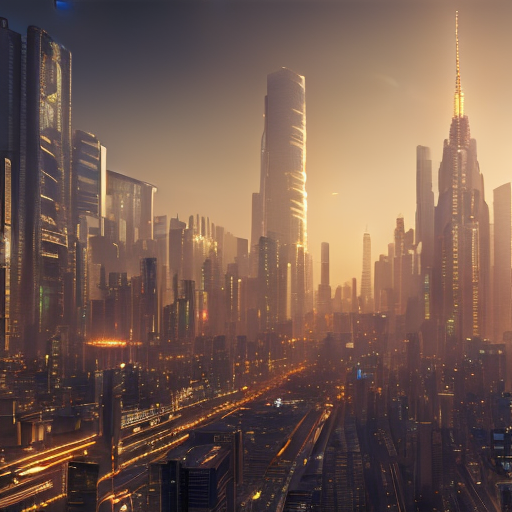

In [17]:
import ipywidgets as widgets

text = '\n\t'.join(text_prompt.value.split('.'))
print("Input text:")
print("\t" + text)
display(final_image)

Nice. As you can see, the picture has quite a high definition 🔥.

<a id="10"></a>
### Image-to-Image generation [&#8657;](#0)

Image-to-Image generation, additionally to text prompt, requires providing initial image. Optionally, you can also change `strength` parameter, which is a value between 0.0 and 1.0, that controls the amount of noise that is added to the input image. Values that approach 1.0 enable lots of variations but will also produce images that are not semantically consistent with the input.

In [18]:
text_prompt_i2i = widgets.Text(value='amazing watercolor painting', description='your text')
num_steps_i2i = widgets.IntSlider(min=1, max=50, value=10, description='steps:')
seed_i2i = widgets.IntSlider(min=0, max=1024, description='seed: ', value=42)
image_widget = widgets.FileUpload(
    accept='',
    multiple=False,
    description='Upload image',
)
strength = widgets.FloatSlider(min=0, max=1, description='strength: ', value=0.5)
widgets.VBox([text_prompt_i2i, seed_i2i, num_steps_i2i, image_widget, strength])

Pipeline settings
Input text: amazing watercolor painting
Seed: 42
Number of steps: 10
Strength: 0.5
Input image:


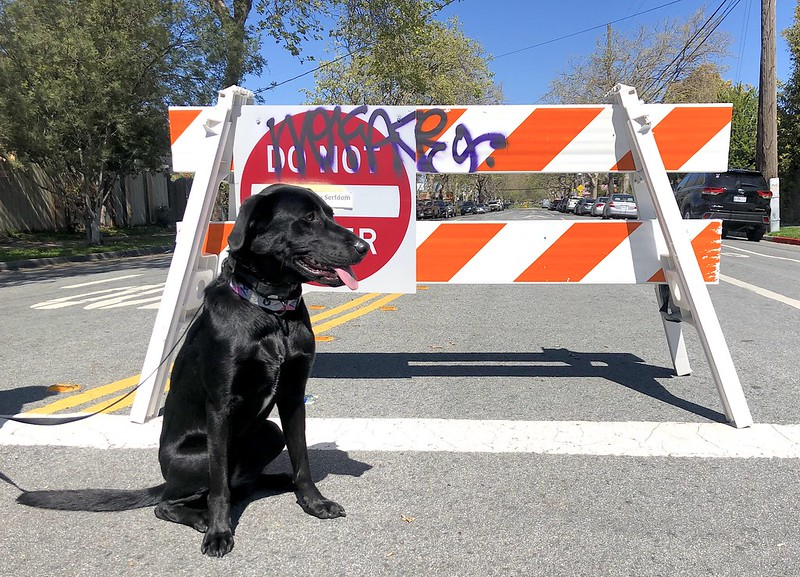

  0%|          | 0/5 [00:00<?, ?it/s]

In [19]:
import io

default_image_path = "../data/image/coco.jpg"
# read uploaded image
image = PIL.Image.open(io.BytesIO(image_widget.value[-1]['content']) if image_widget.value else default_image_path)
print('Pipeline settings')
print(f'Input text: {text_prompt_i2i.value}')
print(f'Seed: {seed_i2i.value}')
print(f'Number of steps: {num_steps_i2i.value}')
print(f'Strength: {strength.value}')
print("Input image:")
display(image)
processed_image = ov_pipe(text_prompt_i2i.value, image, num_inference_steps=num_steps_i2i.value, seed=seed_i2i.value, strength=strength.value)

In [20]:
final_image_i2i = processed_image['sample'][0]
if processed_image['iterations']:
    all_frames_i2i = processed_image['iterations']
    img = next(iter(all_frames_i2i))
    img.save(fp='result_i2i.gif', format='GIF', append_images=iter(all_frames_i2i), save_all=True, duration=len(all_frames_i2i) * 5, loop=0)
final_image_i2i.save('result_i2i.png')

Input text:
	amazing watercolor painting


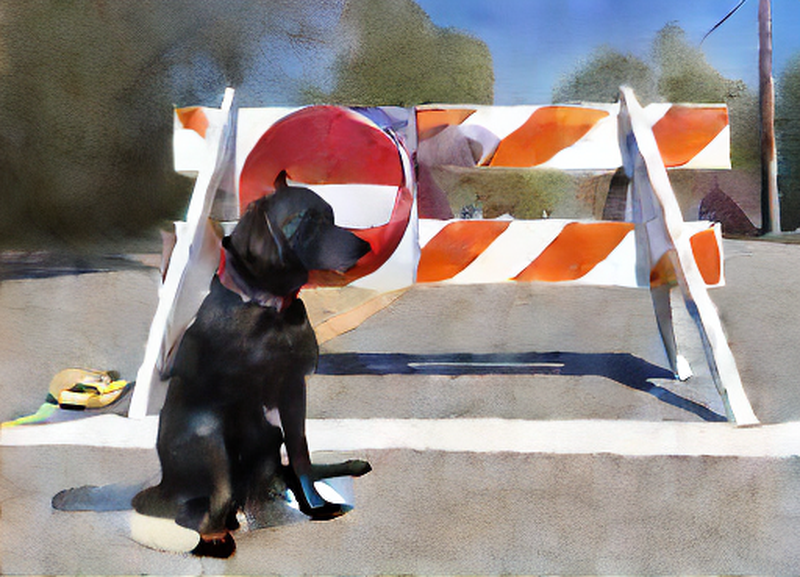

In [21]:
text_i2i = '\n\t'.join(text_prompt_i2i.value.split('.'))
print("Input text:")
print("\t" + text_i2i)
display(final_image_i2i)

## Interactive demo

In [22]:
import gradio as gr
import urllib.request

urllib.request.urlretrieve(
    "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/coco.jpg",
    "coco.jpg"
)


def generate_from_text(text, seed, num_steps, _=gr.Progress(track_tqdm=True)):
    result = ov_pipe(text, num_inference_steps=num_steps, seed=seed)
    return result["sample"][0]


def generate_from_image(img, text, seed, num_steps, strength, _=gr.Progress(track_tqdm=True)):
    result = ov_pipe(text, img, num_inference_steps=num_steps, seed=seed, strength=strength)
    return result["sample"][0]


with gr.Blocks() as demo:
    with gr.Tab("Text-to-Image generation"):
        with gr.Row():
            with gr.Column():
                text_input = gr.Textbox(lines=3, label="Text")
                seed_input = gr.Slider(0, 10000000, value=42, label="Seed")
                steps_input = gr.Slider(1, 50, value=20, step=1, label="Steps")
            out = gr.Image(label="Result", type="pil")
        btn = gr.Button()
        btn.click(generate_from_text, [text_input, seed_input, steps_input], out)
        gr.Examples([[sample_text, 42, 20]], [text_input, seed_input, steps_input])
    with gr.Tab("Image-to-Image generation"):
        with gr.Row():
            with gr.Column():
                i2i_input = gr.Image(label="Image", type="pil")
                i2i_text_input = gr.Textbox(lines=3, label="Text")
                i2i_seed_input = gr.Slider(0, 1024, value=42, label="Seed")
                i2i_steps_input = gr.Slider(1, 50, value=10, step=1, label="Steps")
                strength_input = gr.Slider(0, 1, value=0.5, label="Strength")
            i2i_out = gr.Image(label="Result")
        i2i_btn = gr.Button()
        sample_i2i_text = "amazing watercolor painting"
        i2i_btn.click(
            generate_from_image,
            [i2i_input, i2i_text_input, i2i_seed_input, i2i_steps_input, strength_input],
            i2i_out,
        )
        gr.Examples(
            [["coco.jpg", sample_i2i_text, 42, 10, 0.5]],
            [i2i_input, i2i_text_input, i2i_seed_input, i2i_steps_input, strength_input],
        )

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(share=True, debug=True)
# if you are launching remotely, specify server_name and server_port
# demo.launch(server_name='your server name', server_port='server port in int')
# Read more in the docs: https://gradio.app/docs/

Rerunning server... use `close()` to stop if you need to change `launch()` parameters.
----
Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app
